# Project: Mapping the State-Space of Stem Cell "Decisions"

### 1. Background : Stem Cell Differentiation
In biology, every cell in your body contains the same "source code" (DNA). However, a heart cell behaves differently from a neuron because they are "executing" different parts of that code. However, in order to reach their fates ('final' cell type), cells undergo a journey, the so called **cell differenciation** or **cell specification**. 

Biologists often use the **Waddington Landscape** analogy: imagine a ball rolling down a hilly terrain. At the top (0h), the ball can go down many different valleys. By the bottom (168h), the ball is stuck in one specific path.

![alt text](waddington2.png)


### 2. Data

We quantify this execution by measuring the levels of **Gene Expression** throughout development.

In the current project, the data follows **Mouse Embryonic Stem Cells (ESCs)** over a period of 7 days (168 hours). 
At $T=0$, the cells are "Pluripotent"—think of them as uninitialized objects that have the potential to become almost any tissue type. As time progresses, they interprete gene expression levels as signals to **differentiate**. At the end of the experiement, we get two cell types: **E14** and **R1**.

The **Single-Cell Gene Expression** dataset at our disposal is the following. 
*   **Dimensions:** Each cell is a data object described by **96 features** (different marker genes, in addition to time and type of cell).

| Feature | Type | Description |
| :--- | :--- | :--- |
| **Time** | `int` | The timestamp of the snapshot (0h, 24h, 48h, 72h, 96h, 120h, 168h). |
| **Type** | `string` | The cell line background (**E14** or **R1**). These are two different "classes" of stem cells. |
| **Genes** | `float` | **96 columns** (e.g., *Actb, Nanog, Sox2...*). These represent the normalized expression level of specific genes. |


*** 
*Data Source & Paper: Patrick S. Stumpf, "Stem Cell Differentiation as a Non-Markov Stochastic Process," Cell Systems, 2017.*

### Part 1. Load the dataset
Read the "gene_expression_data.csv" dataset into a pandas dataframe. 

Once loaded, you can use the "head()", "info()" or "describe()" functions for an overview of the dataset and its summary statistics. Below is an example result of head() applied to the dataset.

![alt text](head.png)

Tip: Because the dataset, although high-dimensional, only has 96 columns, you can also open the dataset using Excel and view it in tabular form by using the the "text-to-columns" feature of MS Excel (https://www.youtube.com/watch?v=QyZ6IMkln2U).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For PCA / t-SNE / UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Optional: only if you choose UMAP in Part 5
# pip install umap-learn  (if needed)
# import umap

plt.rcParams["figure.figsize"] = (10, 6)

df = pd.read_csv("gene_expression_data.csv", index_col=0)
df.head()

df.info()
df.describe()

print("Shape:", df.shape)
print("Unique Times:", sorted(df["Time"].unique()))
print("Unique Types:", df["Type"].unique())



<class 'pandas.core.frame.DataFrame'>
Index: 672 entries, E14tg2a.0h.1A to R1.168h.6H
Data columns (total 99 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         672 non-null    int64  
 1   Type         672 non-null    object 
 2   Actb         672 non-null    float64
 3   Bmi1         672 non-null    float64
 4   Bmp4         672 non-null    float64
 5   Bmp7         672 non-null    float64
 6   Bmpr1a       672 non-null    float64
 7   Cd34         672 non-null    float64
 8   Cdh1         672 non-null    float64
 9   Cdh2         672 non-null    float64
 10  Cdk2         672 non-null    float64
 11  Cdx2         672 non-null    float64
 12  Cldn6        672 non-null    float64
 13  Ctcf         672 non-null    float64
 14  Ctnnb1       672 non-null    float64
 15  Dnmt1        672 non-null    float64
 16  Dnmt3b       672 non-null    float64
 17  Dppa3        672 non-null    float64
 18  Dppa4        672 non-null    float64

### Part 2. Visualize some data
Because the dataset is high-dimensional (cells are described across 96 genes), we canNOT visualize all genes. In this part, we will restrict our focus on two genes: "Bmp4" and "Nanog".

Create a figure with two plots (one for each gene), where each plot shows, at each time (0H, 24H, ..., 168H), the statistics of expresssion levels of the genes in cells. What plot types are appropriate for this ?
Hint: you may want to have time on the x-asis  

Bonus: There are two types of cells in the dataset (E14 and R1). Can you enhance the plot to visualize the expression levels within each cell type ? What do you observe ?

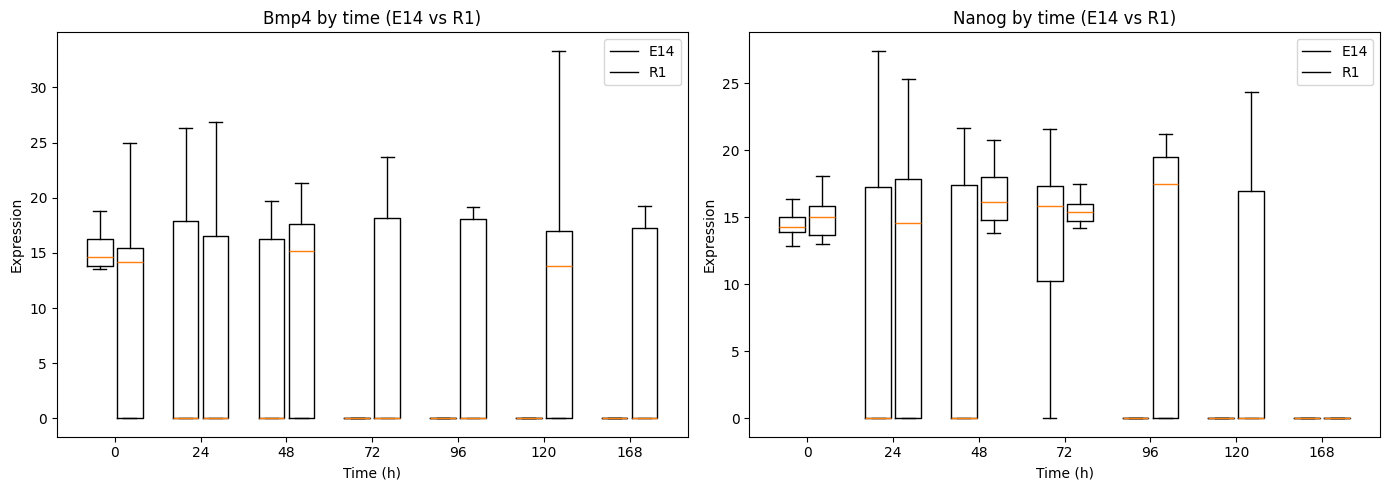

In [3]:

def boxplot_by_time(ax, df, gene, title=None):
    times = sorted(df["Time"].unique())
    data = [df.loc[df["Time"] == t, gene].values for t in times]
    
    ax.boxplot(data, labels=times, showfliers=False)
    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Expression")
    ax.set_title(title if title else gene)

def boxplot_by_time(ax, df, gene, title=None):
    times = sorted(df["Time"].unique())
    data = [df.loc[df["Time"] == t, gene].values for t in times]
    
    ax.boxplot(data, labels=times, showfliers=False)
    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Expression")
    ax.set_title(title if title else gene)

def grouped_boxplot_by_time_and_type(ax, df, gene, title=None):
    times = sorted(df["Time"].unique())
    types = sorted(df["Type"].unique())  # expect ['E14','R1']
    
    positions = np.arange(len(times))
    width = 0.35
    
    for i, typ in enumerate(types):
        data = [df.loc[(df["Time"] == t) & (df["Type"] == typ), gene].values for t in times]
        # offset positions
        pos = positions + (i - 0.5) * width
        ax.boxplot(data, positions=pos, widths=0.3, showfliers=False)
    
    ax.set_xticks(positions)
    ax.set_xticklabels(times)
    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Expression")
    ax.set_title(title if title else f"{gene} by time & type")
    ax.legend([types[0], types[1]], loc="best")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

grouped_boxplot_by_time_and_type(axes[0], df, "Bmp4", "Bmp4 by time (E14 vs R1)")
grouped_boxplot_by_time_and_type(axes[1], df, "Nanog", "Nanog by time (E14 vs R1)")

plt.tight_layout()
plt.show()


### Part 3. Relationships between genes
Because the dataset is high-dimensional (cells are described across 96 genes), we canNOT visualize all relationships between our variables (genes). However, as in almost every real-world datasets, variables entertain strong or weak relations. In this part, we will try to identity which genes that have strong ties, and attempt to visualize how the behave together.

Once more, because the dataset is multi-dimensional, we will restrict our analysis to the subset of genes (although we can get away with an analysis of the whole set of genes in our current scenario of 96 genes) 

    genes = ['Nanog', 'Pou5f1', 'Sox2', 'Gata6', 'Pax6', 'Sox1', 'Actb', 'Bmp4'].

Create a figure with the following plots:

1. A **correlation heatmap** showing the correlations of all genes above at time O
2. A **correlation heatmap** showing the correlations of all genes above at time 168
3. From the first plot, pick the two genes with the highest correlation and create a **scatter plot** of both. Does the scatter trend verify the observed correlation ? Compare their correlation at time 168. What do you observe ?
4. From the second plot, pick the two genes with the highest correlation and create a **scatter plot** of both. Does the scatter trend verify the observed correlation ? Compare their correlation at time 0. What do you observe ?

Bonus: i.Think about improvements you could make on the scatter plots. What comes to mind ? Create a figure with two plots (Hint: different colors and/or markers for the two different cell types, etc.)
ii. How does the relationship of the 2 genes picked at (3.) evolve through all time points (0,24,48,72,69,120,144,168) ? What plot(s) can you use for this ? 

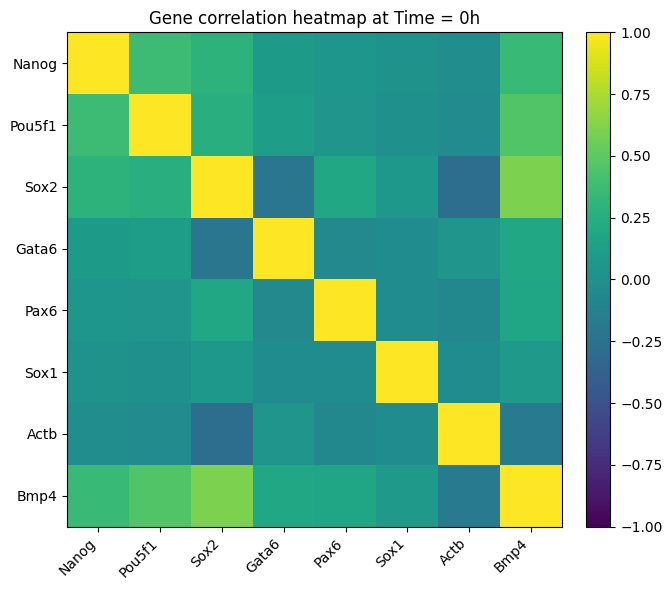

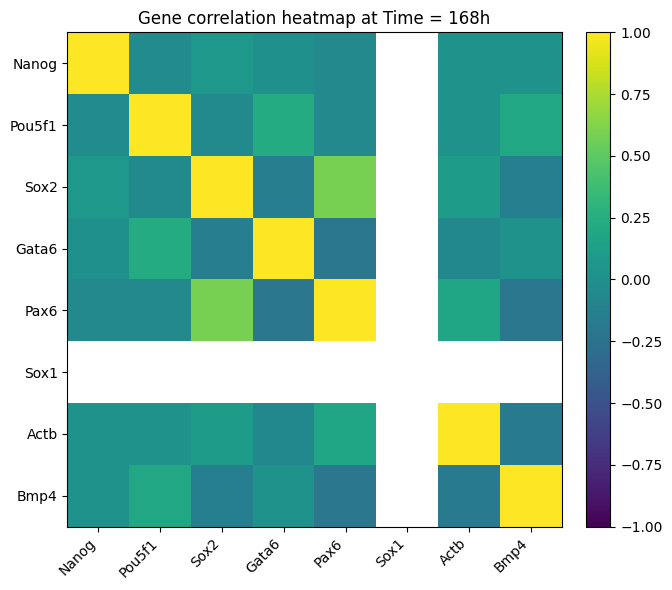

Top pair at Time=0: Sox2 vs Bmp4 corr = 0.6054837459119655
Same pair corr at Time=168: -0.13457341102020912


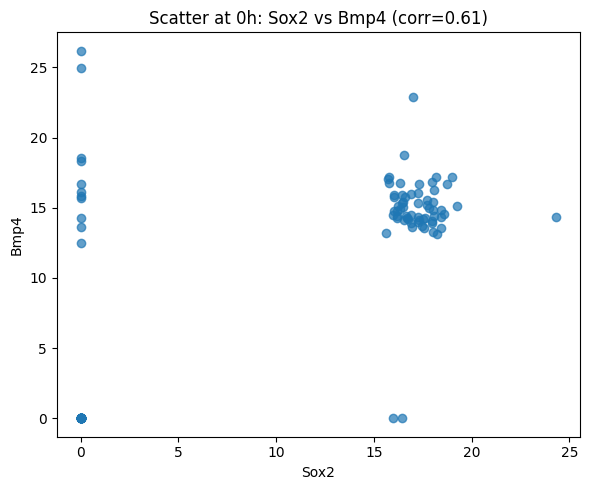

Top pair at Time=168: Sox2 vs Pax6 corr = 0.5936546516833946
Same pair corr at Time=0: 0.19805005919725274


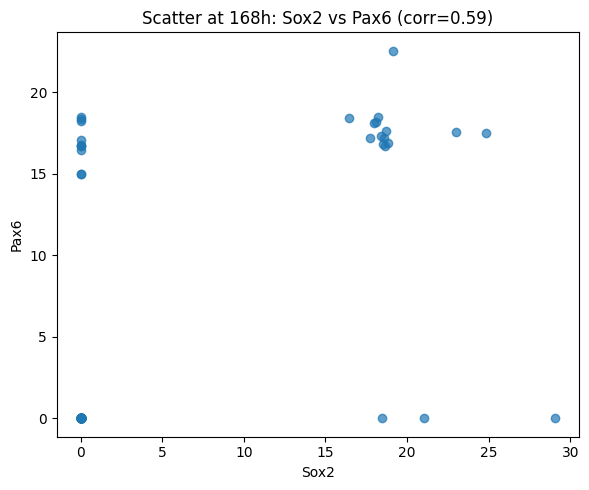

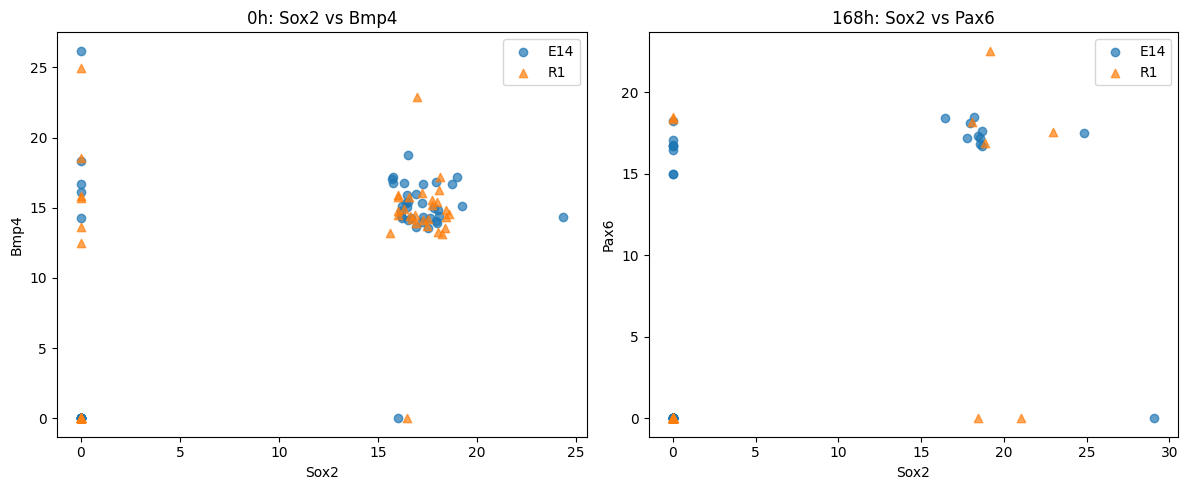

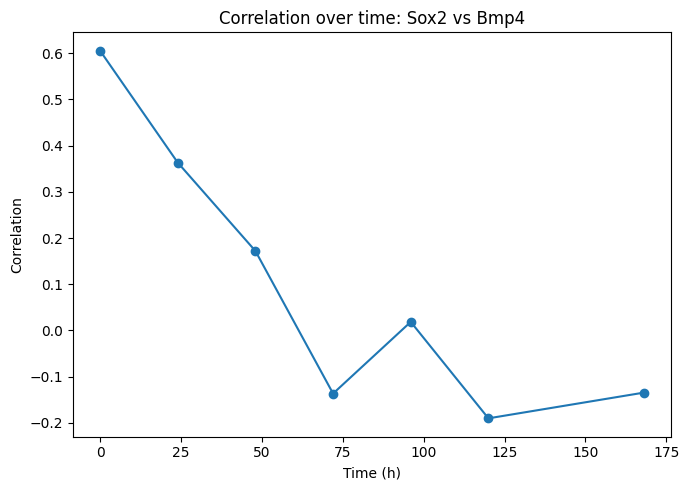

In [5]:

genes = ['Nanog','Pou5f1','Sox2','Gata6','Pax6','Sox1','Actb','Bmp4']

def corr_at_time(df, genes, time_value):
    sub = df.loc[df["Time"] == time_value, genes]
    return sub.corr()

def plot_corr_heatmap(ax, corr, title):
    im = ax.imshow(corr.values, vmin=-1, vmax=1)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.index)))
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(corr.index)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

corr0 = corr_at_time(df, genes, 0)

fig, ax = plt.subplots(figsize=(7, 6))
plot_corr_heatmap(ax, corr0, "Gene correlation heatmap at Time = 0h")
plt.tight_layout()
plt.show()

corr168 = corr_at_time(df, genes, 168)

fig, ax = plt.subplots(figsize=(7, 6))
plot_corr_heatmap(ax, corr168, "Gene correlation heatmap at Time = 168h")
plt.tight_layout()
plt.show()

def top_corr_pair(corr):
    c = corr.copy()
    np.fill_diagonal(c.values, np.nan)
    # get absolute max
    idx = np.nanargmax(np.abs(c.values))
    i, j = np.unravel_index(idx, c.shape)
    gene1 = c.index[i]
    gene2 = c.columns[j]
    return gene1, gene2, c.loc[gene1, gene2]

g1_0, g2_0, r0 = top_corr_pair(corr0)
r168_for_pair0 = corr168.loc[g1_0, g2_0]

print("Top pair at Time=0:", g1_0, "vs", g2_0, "corr =", r0)
print("Same pair corr at Time=168:", r168_for_pair0)

sub0 = df.loc[df["Time"] == 0, ["Type", g1_0, g2_0]]

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(sub0[g1_0], sub0[g2_0], alpha=0.7)
ax.set_xlabel(g1_0)
ax.set_ylabel(g2_0)
ax.set_title(f"Scatter at 0h: {g1_0} vs {g2_0} (corr={r0:.2f})")
plt.tight_layout()
plt.show()

g1_168, g2_168, r168 = top_corr_pair(corr168)
r0_for_pair168 = corr0.loc[g1_168, g2_168]

print("Top pair at Time=168:", g1_168, "vs", g2_168, "corr =", r168)
print("Same pair corr at Time=0:", r0_for_pair168)

sub168 = df.loc[df["Time"] == 168, ["Type", g1_168, g2_168]]

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(sub168[g1_168], sub168[g2_168], alpha=0.7)
ax.set_xlabel(g1_168)
ax.set_ylabel(g2_168)
ax.set_title(f"Scatter at 168h: {g1_168} vs {g2_168} (corr={r168:.2f})")
plt.tight_layout()
plt.show()

def scatter_by_type(ax, data, x, y, title):
    for typ, marker in zip(["E14", "R1"], ["o", "^"]):
        d = data[data["Type"] == typ]
        ax.scatter(d[x], d[y], alpha=0.7, marker=marker, label=typ)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter_by_type(axes[0], sub0, g1_0, g2_0, f"0h: {g1_0} vs {g2_0}")
scatter_by_type(axes[1], sub168, g1_168, g2_168, f"168h: {g1_168} vs {g2_168}")

plt.tight_layout()
plt.show()

times = sorted(df["Time"].unique())
corr_over_time = []

for t in times:
    corr_t = corr_at_time(df, genes, t)
    corr_over_time.append(corr_t.loc[g1_0, g2_0])

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(times, corr_over_time, marker="o")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Correlation")
ax.set_title(f"Correlation over time: {g1_0} vs {g2_0}")
plt.tight_layout()
plt.show()


### Part 4. Dimensionality Reduction (PCA)
We can only do so much in trying to visualize our dataset one variable at the time, or 2 variables at the time. Our dataset is high-dimensional, we must therefore use appropriate methods to visualize it. Most notably, dimensionality reduction methods.

1. Perform **Principal Component Analysis (PCA)** on the data, keeping only 2 dimensions
(Hint: you don't need to pass columns 'Time' and 'Type' to PCA as they do not contain information on genes. Extract just genes columns and pass it to PCA. The line below shows how you can 'drop' those columns)

    X = df.drop(['Time', 'Type'], axis=1)

2. Determine the 'importance' of each of your principal component ? How do you inteprete that ?

3. Create a scatter plot on the resulting two dimensional data (PC1 vs PC2). What do you observe ? Can you identified different trajectories in time for different cell types (E14, R1) ?

4. Enhance the scatter plot using different marker types for cell type (E14, R1) and different colors for time (0, 24, ..., 268). What do you observe ?

Bonus: Perform **Principal Component Analysis (PCA)** on the data, this time keeping 3 dimensions. Redo steps 1-4

NaNs BEFORE cleaning: 672
Gene matrix shape BEFORE cleaning: (672, 97)
All-NaN columns: ['Unnamed: 99']
Gene matrix shape AFTER dropping all-NaN cols: (672, 96)
NaNs AFTER cleaning: 0
Explained variance ratio (PC1, PC2): [0.21367199 0.08065004]
Total explained variance: 0.2943220270234192


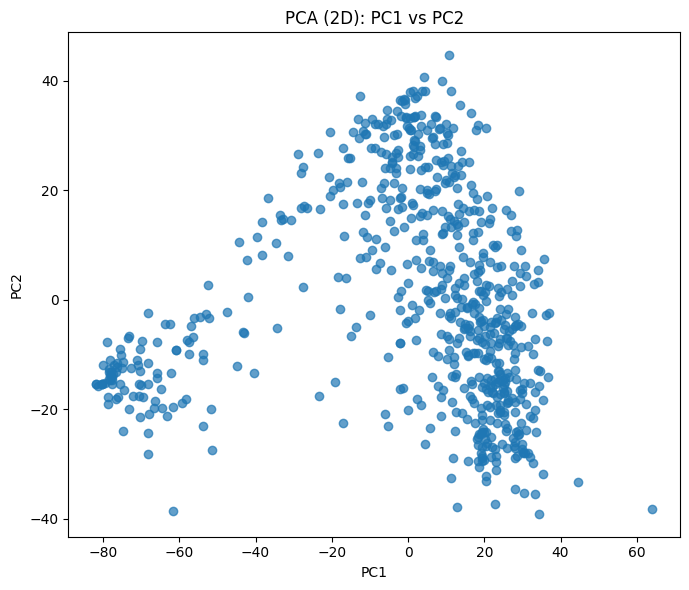

In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ============================================================
# Part 4 — PCA (2 components) [Robust Fix]
# Key fix: drop columns that are ALL NaN, then impute remaining NaNs
# ============================================================

# 1) Extract gene expression only (remove metadata)
gene_df = df.drop(columns=["Time", "Type"]).copy()

# 2) Force numeric conversion (safety)
gene_df = gene_df.apply(pd.to_numeric, errors="coerce")

# 3) Diagnose NaNs
total_nans_before = gene_df.isna().sum().sum()
print("NaNs BEFORE cleaning:", total_nans_before)
print("Gene matrix shape BEFORE cleaning:", gene_df.shape)

# 4) DROP columns that are entirely NaN (this is the critical fix)
all_nan_cols = gene_df.columns[gene_df.isna().all()].tolist()
print("All-NaN columns:", all_nan_cols)

gene_df = gene_df.drop(columns=all_nan_cols)

print("Gene matrix shape AFTER dropping all-NaN cols:", gene_df.shape)

# 5) Impute any remaining NaNs using column medians
gene_df = gene_df.fillna(gene_df.median(numeric_only=True))

# 6) Confirm no NaNs remain
total_nans_after = gene_df.isna().sum().sum()
print("NaNs AFTER cleaning:", total_nans_after)

# Hard stop if still broken (so you don't waste time)
assert total_nans_after == 0, "Still have NaNs after cleaning. Check printed All-NaN columns."

# 7) Run PCA with 2 components
X = gene_df.to_numpy()

pca2 = PCA(n_components=2)
X2 = pca2.fit_transform(X)

print("Explained variance ratio (PC1, PC2):", pca2.explained_variance_ratio_)
print("Total explained variance:", pca2.explained_variance_ratio_.sum())

# 8) Basic PCA scatter plot
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(X2[:, 0], X2[:, 1], alpha=0.7)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA (2D): PC1 vs PC2")
plt.tight_layout()
plt.show()



### Part 5. Dimensionality Reduction (Non-linear methods)
Non-linear dimensionality reduction (t-SNE, UMAP) methods usually produce better visualisations than PCA

1. Redo steps 1,3,4 of the previous part (keeping only 2 components, then 3 components) using a non-linear reduction method of your choice (**t-SNE** or **UMAP**). What do you observe ? How is the visulisation produced compared to the visual result of PCA ?


Bonus: Redo step 1 using the dimensionality reduction method **isomap** (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html)

C:\Users\nakkz\AppData\Local\Temp\ipykernel_61804\3650562804.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(times))


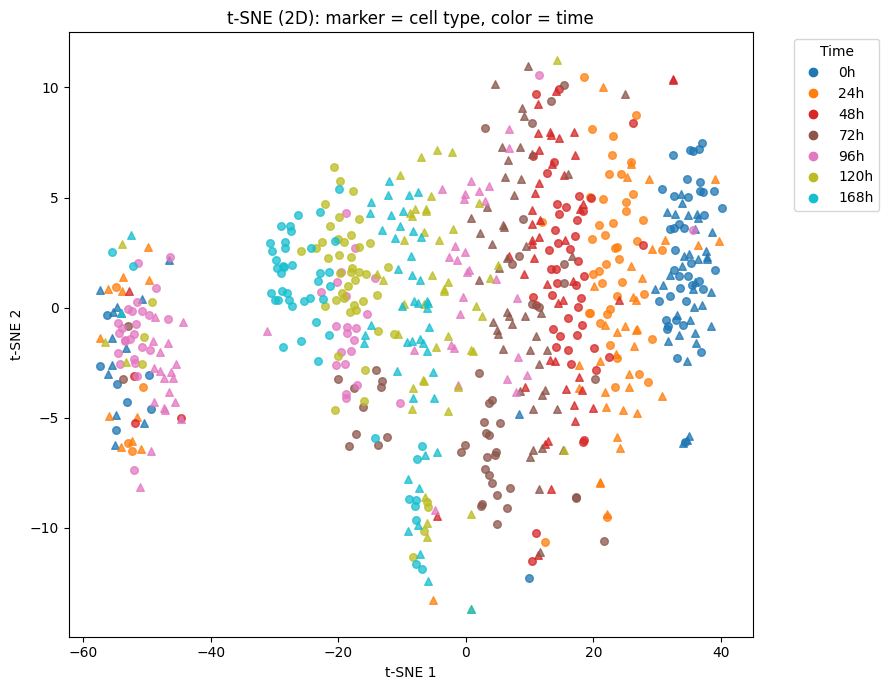

In [14]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# Part 5 — Non-linear dimensionality reduction (t-SNE, 2D)
# ============================================================

# Use the SAME cleaned gene matrix as PCA
# (gene_df was created in Part 4 and has no NaNs)
X = gene_df.to_numpy()

# Run t-SNE (2 components)
tsne2 = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)

X_tsne = tsne2.fit_transform(X)

# ------------------------------------------------------------
# Plot: marker = Type, color = Time (DISCRETE)
# ------------------------------------------------------------
times = sorted(df["Time"].unique())
cmap = plt.cm.get_cmap("tab10", len(times))

fig, ax = plt.subplots(figsize=(9, 7))

for i, t in enumerate(times):
    for cell_type, marker in zip(["E14", "R1"], ["o", "^"]):
        mask = (df["Time"] == t) & (df["Type"] == cell_type)
        ax.scatter(
            X_tsne[mask, 0],
            X_tsne[mask, 1],
            color=cmap(i),
            marker=marker,
            s=30,
            alpha=0.75
        )

ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE (2D): marker = cell type, color = time")

# Legend for time only
handles = [
    plt.Line2D([0], [0], marker="o", color=cmap(i), linestyle="", label=f"{t}h")
    for i, t in enumerate(times)
]
ax.legend(
    handles=handles,
    title="Time",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()



A two-dimensional t-SNE embedding reveals clearer structure than PCA. Cells cluster according to developmental time, with early, intermediate, and late time points occupying distinct regions of the embedding. Compared to PCA, t-SNE better captures non-linear relationships in the data and highlights differentiation trajectories, with partial separation between E14 and R1 cell types at later stages.

C:\Users\nakkz\AppData\Local\Temp\ipykernel_61804\3678898429.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(times))


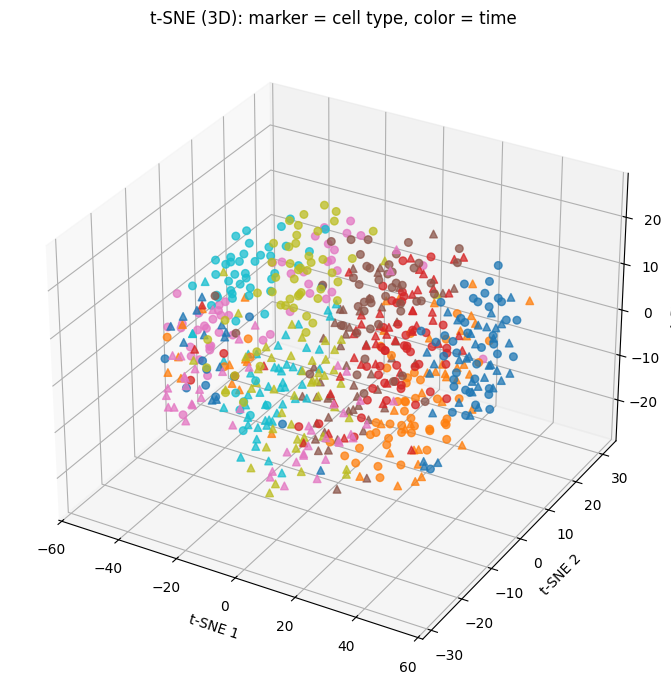

In [15]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
import matplotlib.pyplot as plt

# ============================================================
# Part 5 — Bonus: t-SNE (3D)
# ============================================================

# Use the same cleaned gene matrix
X = gene_df.to_numpy()

# Run t-SNE with 3 components
tsne3 = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)

X_tsne3 = tsne3.fit_transform(X)

# ------------------------------------------------------------
# 3D Scatter plot: marker = Type, color = Time
# ------------------------------------------------------------
times = sorted(df["Time"].unique())
cmap = plt.cm.get_cmap("tab10", len(times))

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

for i, t in enumerate(times):
    for cell_type, marker in zip(["E14", "R1"], ["o", "^"]):
        mask = (df["Time"] == t) & (df["Type"] == cell_type)
        ax.scatter(
            X_tsne3[mask, 0],
            X_tsne3[mask, 1],
            X_tsne3[mask, 2],
            color=cmap(i),
            marker=marker,
            s=30,
            alpha=0.75
        )

ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.set_title("t-SNE (3D): marker = cell type, color = time")

plt.tight_layout()
plt.show()



### Bonus: 3D t-SNE visualization

The 3D t-SNE visualization is shown as a static figure in this environment. The overall structure is consistent with the 2D t-SNE embedding and does not qualitatively change the observed clustering or differentiation trajectories.
